In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from scipy.optimize import minimize

plt.style.use("./notebook.mplstyle")
print(modelbase.__version__)

1.3.6


In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture
cd analyses/

In [5]:
def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


def pfd_scan(s, pfd_values, y0_loop):
    fluxes = {}
    concentrations = {}
    for i, x in tqdm(enumerate(pfd_values), total=len(pfd_values)):
        s.initialise(y0_loop)
        s.update_parameter("pfd", x)
        try:
            t, y = s.simulate(T_END)
            concentrations[x] = dict(s.get_full_results_df().iloc[-1])
            fluxes[x] = dict(s.get_fluxes_df().iloc[-1])
            # Model is sensitive to initial conditions, so set the last ones every loop
            y0_loop = get_new_y0(s)
        except:
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            concentrations[x] = dict(
                zip(all_compounds), np.full(len(all_compounds), np.nan)
            )
            fluxes[x] = dict(zip(rate_names, np.full(len(rate_names), np.nan)))
    return pd.DataFrame(concentrations).T, pd.DataFrame(fluxes).T


NUM_SCANS = 50
T_END = 100_000
LOW_LIGHT = 50
HIGH_LIGHT = 1500
PFD_VALUES = np.linspace(LOW_LIGHT, HIGH_LIGHT, NUM_SCANS)

y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [6]:
s = Simulator(get_model())
s.update_parameters({"pfd": 40.0})
conc_petc_mehler, flux_petc_mehler = pfd_scan(
    s, pfd_values=PFD_VALUES, y0_loop=y0
)

  0%|          | 0/50 [00:00<?, ?it/s]

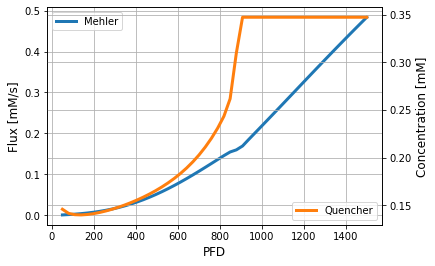

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(flux_petc_mehler["vMehler"], label="Mehler")
ax1.set(xlabel="PFD", ylabel="Flux [mM/s]")
ax1.legend(loc="upper left", borderaxespad=0.5)
ax2.plot(conc_petc_mehler["Q"], color="C1", label="Quencher")
ax2.set(ylabel="Concentration [mM]")
ax2.legend(loc="lower right", borderaxespad=0.5)
plt.show()

In [8]:
def relative_to_max(df, names, max_=None):
    if max_ is None:
        return df.loc[:, names] * 100 / df.loc[:, names].max()
    else:
        return df.loc[:, names] * 100 / max_

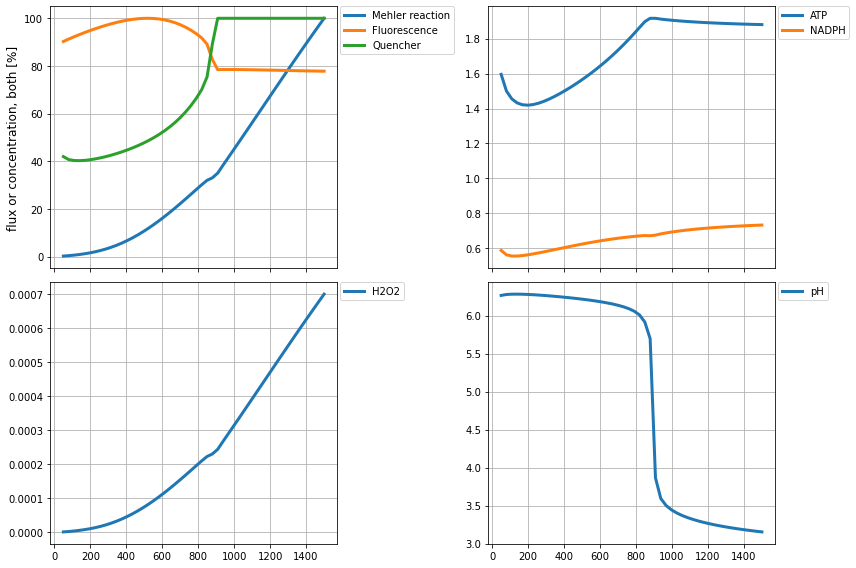

In [9]:
# rates: "vMehler", vDeepox", "vEpox", "vLhcdeprotonation", vLhcprotonation"
# concentrations : "Fluo", "Q"

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
ax1, ax2, ax3, ax4 = axs.ravel()

relative_to_max(flux_petc_mehler, "vMehler").plot(ax=ax1, label="Mehler reaction")
relative_to_max(conc_petc_mehler, "Fluo").plot(ax=ax1, label="Fluorescence")
relative_to_max(conc_petc_mehler, "Q").plot(ax=ax1, label="Quencher")
# compensation_point = flux_petc_mehler["vMehler"].diff().diff().idxmax()
# ax.axvline(compensation_point, color=(0, 0, 0, 1 / 6), linestyle="dashed")
# ax.axvspan(compensation_point - 25, compensation_point + 25, color=(0, 0, 0, 1 / 16))
ax1.set(
    xlabel="PFD",
    ylabel="flux or concentration, both [%]",
    #     title=f"Compensation point ≈ {compensation_point:.0f} PFD",
)

conc_petc_mehler.loc[:, ["ATP", "NADPH"]].plot(ax=ax2)
conc_petc_mehler.loc[:, ["H2O2"]].plot(ax=ax3)
conc_petc_mehler.loc[:, ["pH"]].plot(ax=ax4)
# flux_petc_mehler.loc[:,  ["v9"]].plot(ax=ax4)

for ax in axs.ravel():
    ax.legend(bbox_to_anchor=(1.01, 1))
fig.tight_layout()
plt.show()

In [10]:
s = Simulator(get_model())
s.initialise(y0)
s.update_parameter("pfd", 300)
s.simulate(100_000)
y0_petc_mehler_300 = get_new_y0(s)

In [11]:
s = Simulator(get_model())
s.initialise(y0_petc_mehler_300)
s.update_parameter("pfd", 600)
s.simulate(100_000)
y0_petc_mehler_600 = get_new_y0(s)

In [12]:
def get_experiment(pfd_and_duration):
    experiment = []
    t_start = 0
    t_end = 0
    for pfd, duration in pfd_and_duration:
        t_end += duration
        experiment.append((pfd, t_start, t_end))
        t_start = t_end
    return experiment

In [13]:
def analyse_and_plot_changing_light(s):
    concentrations = s.get_full_results_df()
    fluxes = s.get_fluxes_df()
    fig, ax = plt.subplots(figsize=(12, 8))
    # normalize to simulation max
    relative_to_max(fluxes, "vMehler").plot(ax=ax, label="Mehler reaction")
    # normalize to simulation max
    relative_to_max(concentrations, "Fluo").plot(ax=ax, label="Fluorescence")
    # normalize to simulation max
    relative_to_max(concentrations, "Q").plot(ax=ax, label="Quencher")
    # normalize to calculated max
#     relative_to_max(concentrations, "Q", QUENCHER_MAX).plot(ax=ax, label="Quencher")

    max_pfd = max(experiment)[0]
    for pfd, t_start, t_end in experiment:
        ax.axvspan(t_start, t_end, color=(0, 0, 0, 1 / 8 * (1 - pfd / max_pfd)))
        ax.annotate(pfd, ((t_start + t_end) / 2, 100), ha="center")
    ax.legend(bbox_to_anchor=(1.01, 1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60.0))
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f"{x / 60:.0f} min")
    )
    ax.grid(None)
    plt.show()

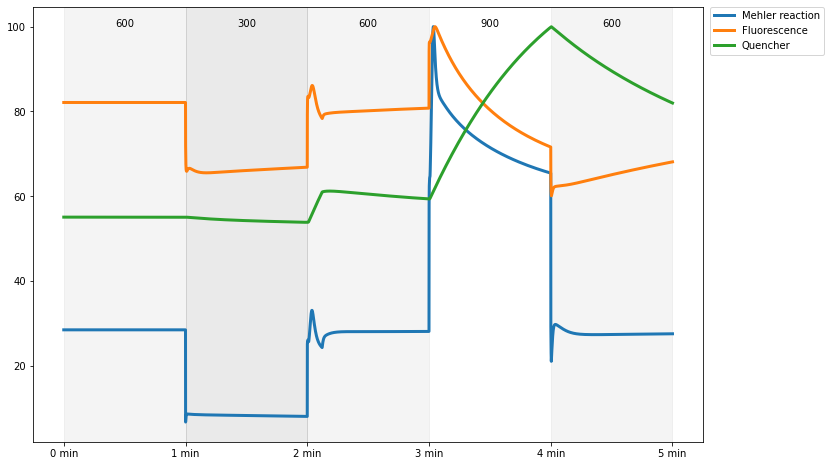

In [14]:
s = Simulator(get_model())
s.update_parameters({"pfd": 40})
experiment = get_experiment(
    [
        (600, 60),
        (300, 60),
        (600, 60),
        (900, 60),
        (600, 60),
    ]
)

s.initialise(y0_petc_mehler_600)
for pfd, _, t_end in experiment:
    s.update_parameter("pfd", pfd)
    s.simulate(t_end)

analyse_and_plot_changing_light(s)

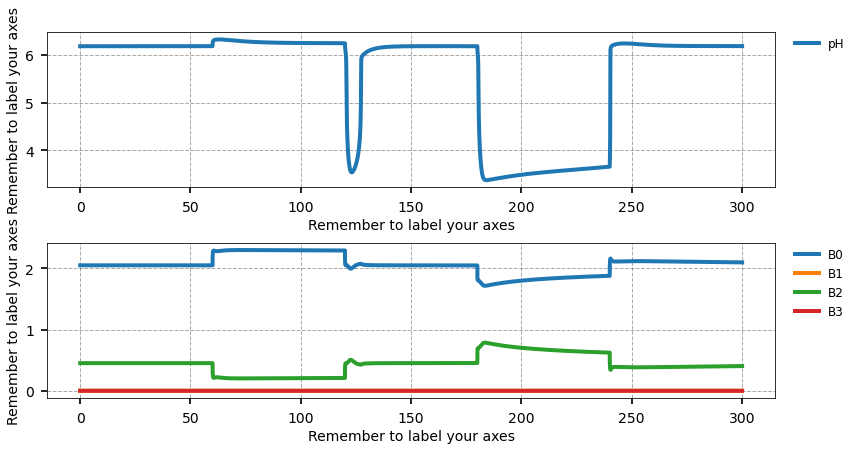

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
s.plot_selection(["pH"], ax=ax1)
s.plot_selection(["B0", "B1", "B2", "B3"], ax=ax2)
fig.tight_layout()

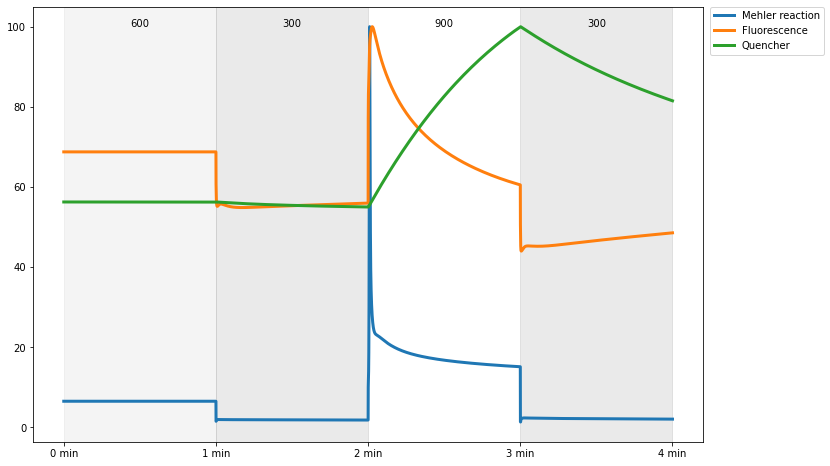

In [16]:
s = Simulator(get_model())
s.update_parameters({"pfd": 40})
experiment = get_experiment(
    [
        (600, 60),
        (300, 60),
        (900, 60),
        (300, 60),
    ]
)

s.initialise(y0_petc_mehler_600)
for pfd, _, t_end in experiment:
    s.update_parameter("pfd", pfd)
    s.simulate(t_end)

analyse_and_plot_changing_light(s)